In [1]:
import sys
if "../.." not in sys.path: sys.path.insert(0, "../..")
if ".." not in sys.path: sys.path.insert(0, "..")

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

from experiment.v1dd_client import V1DDClient
from experiment.v1dd_ophys_session import V1DDOPhysSession
from stimulus_analysis.locally_sparse_noise import LocallySparseNoise
from stimulus_analysis.timing_utils import find_nearest, get_frame_window_from_time_window
from statsmodels.sandbox.stats.multicomp import multipletests

%load_ext autoreload
%autoreload 2

/var/folders/8l/944wpj6s7sq8gcv57wcd3q6h0000gn/T/ipykernel_1959/4042779375.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# windows
# base_folder = r"\\allen\programs\mindscope\workgroups\surround\v1dd_in_vivo_new_segmentation\data"

# # linux and mac
# base_folder = "/allen/programs/mindscope/workgroups/surround/v1dd_in_vivo_new_segmentation/data"
# base_folder = "/Volumes/programs/mindscope/workgroups/surround/v1dd_in_vivo_new_segmentation/data"
base_folder = "/Users/chase/Desktop/test_v1dd_data"
client = V1DDClient(base_folder)

In [3]:
mouse = 409828
col, vol = 1, 3
sess = client.load_ophys_session(mouse=mouse, column=col, volume=vol)
print(f"Loaded ophys session {sess.get_session_id()} (mouse {sess.get_mouse_id()}, column {sess.get_column_id()}, volume {sess.get_volume_id()})")

Loaded ophys session M409828_13 (mouse 409828, column 1, volume 3)


In [4]:
plane = sess.get_planes()[0]
print(f"Analyzing plane {plane}")

Analyzing plane 1


In [5]:
lsn = LocallySparseNoise(sess, plane)

In [9]:
lsn.sweep_responses.shape

(1705, 1234)

In [10]:
lsn.design_matrix.shape

(224, 1705)

In [15]:
lsn.image_shape

(8, 14)

In [45]:
def get_stim_showing_events(lsn, method="mean"):
    """
    Get a matrix of shape (n_sweeps, n_rois) representing neural responses
    to each stimulus showing.

    Args:
        lsn (_type_): _description_
        method (str, optional): _description_. Defaults to "mean".

    Returns:
        _type_: _description_
    """
    # Assumes events and timestamps are 1d arrays corresponding to a single ROI
    stim_sweep_events = np.empty((lsn.n_sweeps, lsn.n_rois))

    for stim_i, stim in lsn.stim_table.iterrows():
        start = find_nearest(lsn.event_timestamps, stim["start"], direction=-1)
        end = find_nearest(lsn.event_timestamps, stim["end"])
        mean_event = lsn.event_traces[:, start:end+1].mean(axis=1)

        if method == "mean":
            event = mean_event
        elif method == "binary":
            event = mean_event > 0
        else:
            raise NotImplementedError()

        stim_sweep_events[stim_i] = event

    return stim_sweep_events


def get_sta(lsn, design_matrix, sweep_events):
    sta = design_matrix.dot(sweep_events)
    shape = (-1, *lsn.image_shape) # (n_rois, n_rows, n_cols)
    sta_on = sta[:lsn.n_pixels].reshape(shape)
    sta_off = sta[lsn.n_pixels:].reshape(shape)

    return sta_on, sta_off



def get_shuffled_pixelwise_responses(lsn, design_matrix, stim_showing_events, n_shuffles=5000, seed=1):
    """_summary_

    Args:
        lsn (_type_): _description_
        design_matrix (np.ndarray): Of shape (2*n_pixels, n_stim_showings)
        stim_showing_events (np.ndarray): Of shape (n_sweeps, n_rois)
        n_shuffles (int, optional): _description_. Defaults to 5000.
        seed (int, optional): _description_. Defaults to 1.

    Returns:
        np.ndarray: Of shape (2*n_pixels, n_rois, n_stim_showings)
    """
    np.random.seed(seed)
    shuffled_stas = np.zeros((2*lsn.n_pixels, lsn.n_rois, n_shuffles))
    
    for shuffle_i in tqdm(range(n_shuffles)):
        # Choose random stimulus showings, with replacement
        random_stim_idx = np.random.randint(low=0, high=lsn.n_sweeps, size=lsn.n_sweeps)
        shuffled_events = stim_showing_events[random_stim_idx, :] # shape (n_sweeps, n_rois)
        shuffled_stas[:, :, shuffle_i] = design_matrix.dot(shuffled_events) # shape (2*n_pixels, n_rois)

    return shuffled_stas


def events_to_pvals_no_fdr_correction(lsn, design_matrix, stim_showing_events, n_shuffles=5000, seed=1):
    """_summary_

    Args:
        lsn (_type_): _description_
        design_matrix (_type_): _description_
        stim_showing_events (_type_): _description_
        n_shuffles (int, optional): _description_. Defaults to 5000.
        seed (int, optional): _description_. Defaults to 1.

    Returns:
        np.ndarray: Of shape (2*n_pixels, n_rois)
    """
    shuffled_stas = get_shuffled_pixelwise_responses(lsn, design_matrix, stim_showing_events, n_shuffles=n_shuffles, seed=seed)
    # ^ shuffled_stas.shape = (2*n_pixels, n_rois, n_shuffles)

    # p values are the fraction of times the shuffled response at each pixel is greater than
    # the actual observed response to that pixel
    sta = design_matrix.dot(stim_showing_events) # shape (2*n_pixels, n_rois)
    p_values = np.mean(shuffled_stas > sta.reshape(*sta.shape, 1), axis=2)
    return p_values

In [81]:
p_values = events_to_pvals_no_fdr_correction(lsn, lsn.design_matrix, lsn.sweep_responses, n_shuffles=5000, seed=1)
p_values.shape


  0%|          | 0/5000 [00:00<?, ?it/s]

In [82]:
from statsmodels.sandbox.stats.multicomp import multipletests

def correct_pvals(p_values, axis=0):
    f = lambda p: multipletests(p, method="hs")[1]
    p_values_corrected = np.apply_along_axis(f, axis, p_values)
    return p_values_corrected

p_values_corrected = correct_pvals(p_values)
p_values.shape


(224, 1234)

In [83]:
p_values_corrected.shape

(224, 1234)

In [85]:
# Find the percentage of valid ROIs that are responsive
# (Responsive = have at least one on or off pixel that is significant)
is_responsive = (np.sum(p_values_corrected < 0.05, axis=0) > 0)[lsn.is_roi_valid]
is_responsive.mean()

0.15647921760391198

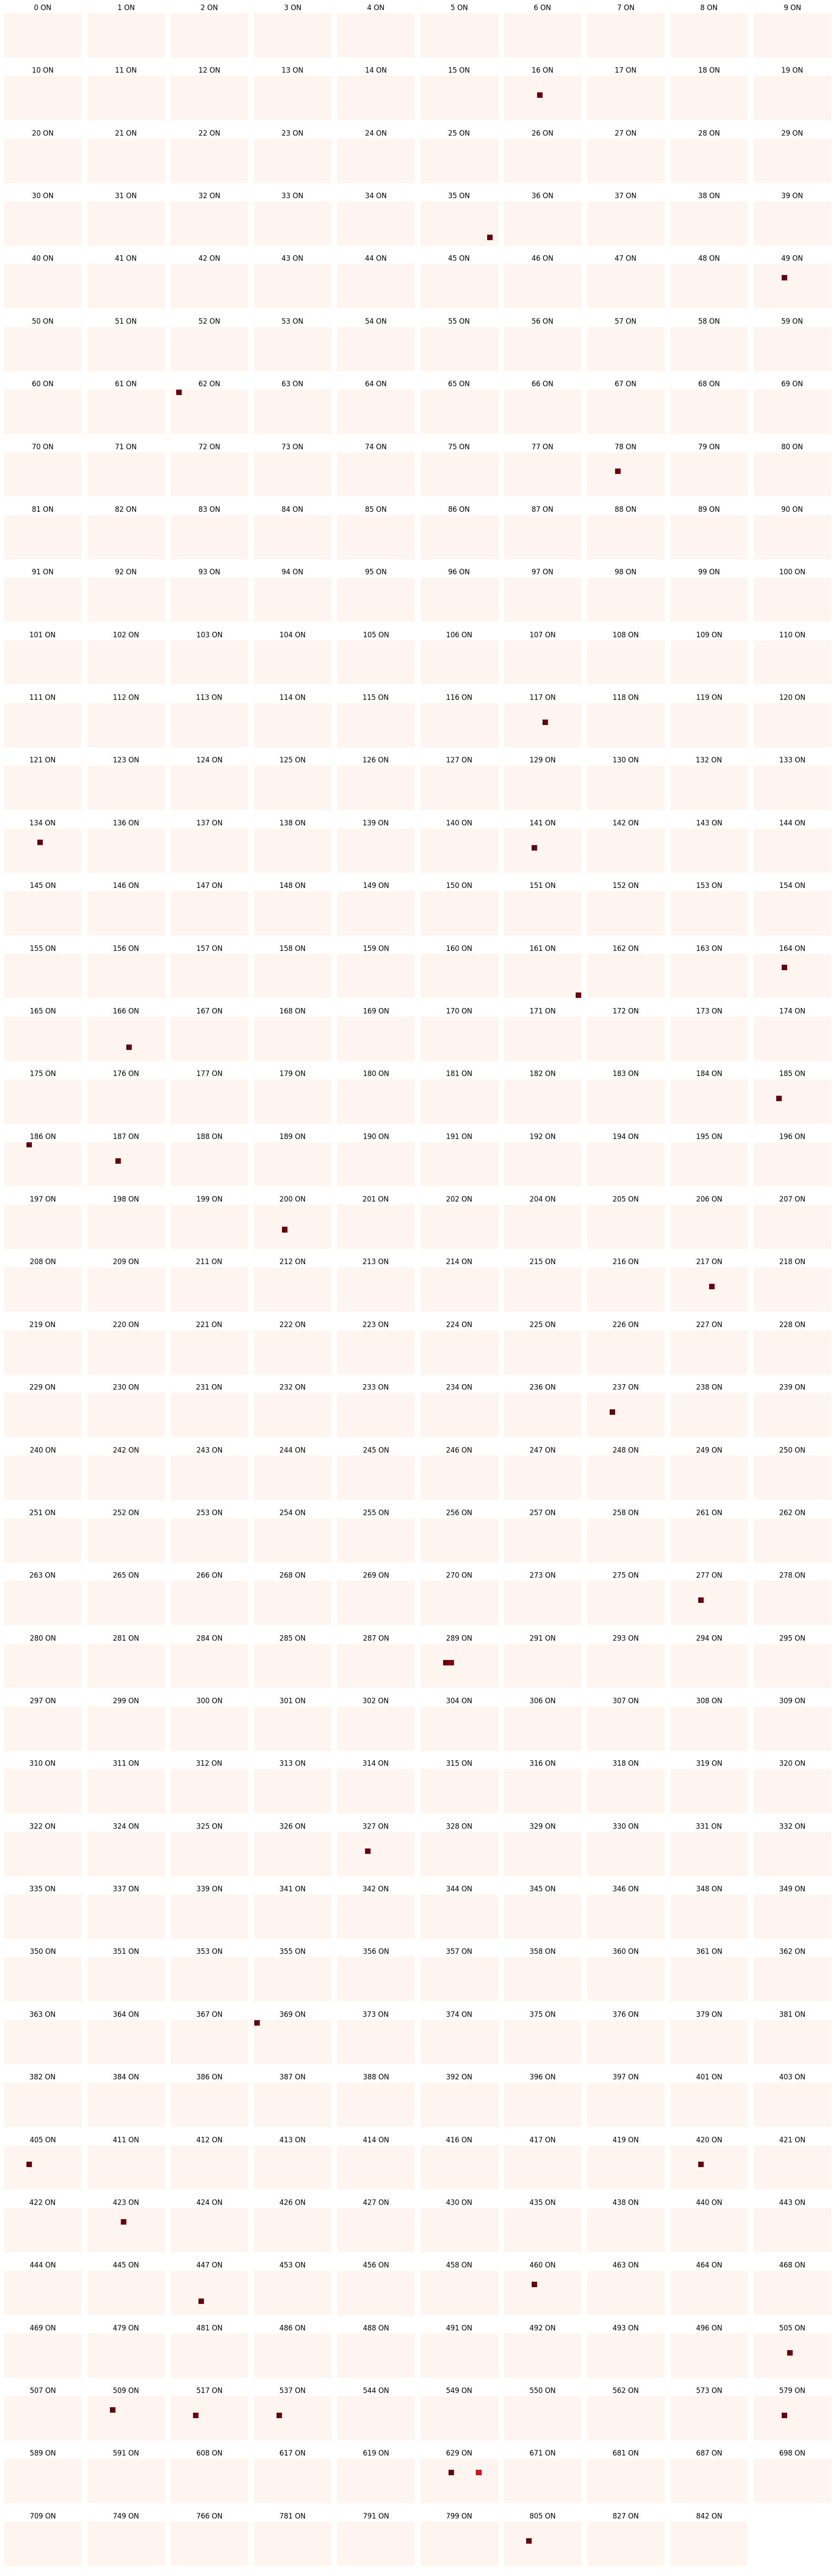

In [87]:
sta = lsn.design_matrix.dot(lsn.sweep_responses) # shape (2*n_pixels, n_rois)
valid_rois = np.where(lsn.is_roi_valid)[0]
plot_on = True
cmap = "Reds" if plot_on else "Blues"
pixel_idx = slice(lsn.n_pixels) if plot_on else slice(lsn.n_pixels, sta.shape[0])

ncols = 10
nrows = int(np.ceil(len(valid_rois) / ncols))
fig, axs = plt.subplots(figsize=(2*ncols, 1.5*nrows), nrows=nrows, ncols=ncols)
axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.axis("off")

    if i < len(valid_rois):
        roi = valid_rois[i]
        rf = sta[pixel_idx, roi]
        rf = rf * (p_values_corrected[pixel_idx, roi] < 0.05)
        rf = rf.reshape(lsn.image_shape)
        
        ax.imshow(rf, cmap=cmap)
        ax.set_title(f"{roi} {'ON' if plot_on else 'OFF'}")

# fig.suptitle("ON" if plot_on else "OFF")
fig.tight_layout()

## Miscellaneous

In [6]:
from scipy.interpolate import interp2d
from scipy.ndimage import gaussian_filter
from skimage.measure import block_reduce

def convolve(img, sigma=4):
    '''
    2D Gaussian convolution.

    Copied from https://github.com/AllenInstitute/AllenSDK/blob/9ef5214dcb04a61fe4c04bf19a5cb13c9e1b03f1/allensdk/brain_observatory/receptive_field_analysis/utilities.py#L56
    '''

    if img.sum() == 0:
        return img

    img_pad = np.zeros((3 * img.shape[0], 3 * img.shape[1]))
    img_pad[img.shape[0]:2 * img.shape[0], img.shape[1]:2 * img.shape[1]] = img

    x = np.arange(3 * img.shape[0])
    y = np.arange(3 * img.shape[1])
    g = interp2d(y, x, img_pad, kind='linear')

    if img.shape[0] == 16:
        upsample = 4
        offset = -(1 - .625)
    elif img.shape[0] == 8:
        upsample = 8
        offset = -(1 - .5625)
    else:
        raise NotImplementedError
        
    ZZ_on = g(offset + np.arange(0, img.shape[1] * 3, 1. / upsample), offset + np.arange(0, img.shape[0] * 3, 1. / upsample))
    ZZ_on_f = gaussian_filter(ZZ_on, float(sigma), mode='constant')

    z_on_new = block_reduce(ZZ_on_f, (upsample, upsample))
    z_on_new = z_on_new / z_on_new.sum() * img.sum()
    z_on_new = z_on_new[img.shape[0]:2 * img.shape[0], img.shape[1]:2 * img.shape[1]]

    return z_on_new

In [42]:
def get_design_matrix(lsn: LocallySparseNoise, blur: bool=False):
    """
    Design matrix is a matrix of shape (2*n_pixels, n_stim_showings) that contains
    information about what pixels are ON or OFF in different stimulus showings. A
    stimulus condition is a particular showing of a stimulus (that need not be unique).
    
    Specifically, the first half of rows are indexed by (i, j) where i is 1 iff pixel i is ON in stimulus condition j.
    The second half of rows are indexed by (n_pixels+i, j) where i is 1 iff pixel i is OFF in stimulus condition j.
    
    If blur is true, the matrix is convolved with a 2D Gaussian.

    Args:
        lsn (LocallySparseNoise): _description_
        blur (bool, optional): Whether to "blur" the matrix with a Gaussian kernel. Defaults to False.

    Returns:
        np.ndarray: Of shape (2*n_pixels, n_stimulus_conditions)
    """
    # 
    design_matrix = np.zeros((2*lsn.n_pixels, lsn.n_stim_showings), dtype=(float if blur else bool))

    for stim_condition_index, frame in lsn.stim_table["frame"].items():
        frame_pixels = lsn.frame_images[frame].flatten()
        design_matrix[:lsn.n_pixels, stim_condition_index] = (frame_pixels == lsn.pixel_on).astype(design_matrix.dtype)
        design_matrix[lsn.n_pixels:, stim_condition_index] = (frame_pixels == lsn.pixel_off).astype(design_matrix.dtype)
    
    if blur:
        for stim_condition_index in range(design_matrix.shape[1]):
            design_matrix[:lsn.n_pixels, stim_condition_index] = convolve(design_matrix[:lsn.n_pixels, stim_condition_index].reshape(lsn.image_shape)).flatten()
            design_matrix[lsn.n_pixels:, stim_condition_index] = convolve(design_matrix[lsn.n_pixels:, stim_condition_index].reshape(lsn.image_shape)).flatten()

    return design_matrix

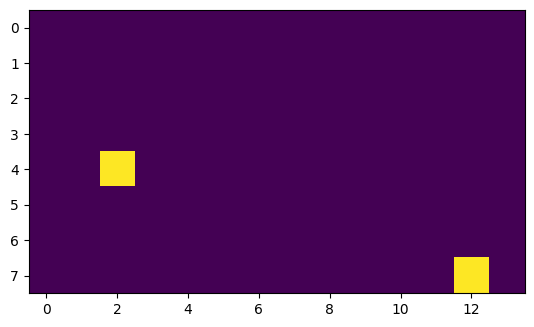

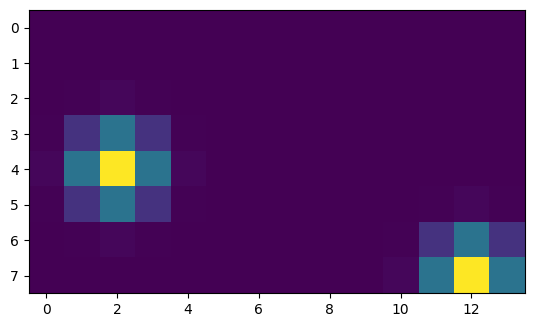

In [30]:
plt.imshow(get_design_matrix(lsn, blur=False)[:lsn.n_pixels, 0].reshape(lsn.image_shape))
plt.figure()
plt.imshow(get_design_matrix(lsn, blur=True)[:lsn.n_pixels, 0].reshape(lsn.image_shape))

In [40]:
def get_stim_showing_events(lsn, method="mean"):
    """
    Get a matrix of shape (n_stim_showings, n_rois) representing neural responses
    to each stimulus showing.

    Args:
        lsn (_type_): _description_
        method (str, optional): _description_. Defaults to "mean".

    Returns:
        _type_: _description_
    """
    # Assumes events and timestamps are 1d arrays corresponding to a single ROI
    stim_sweep_events = np.empty((lsn.n_stim_showings, lsn.n_rois))

    for stim_i, stim in lsn.stim_table.iterrows():
        start = find_nearest(lsn.event_timestamps, stim["start"], direction=-1)
        end = find_nearest(lsn.event_timestamps, stim["end"])
        mean_event = lsn.event_traces[:, start:end+1].mean(axis=1)

        if method == "mean":
            event = mean_event
        elif method == "binary":
            event = mean_event > 0
        else:
            raise NotImplementedError()

        stim_sweep_events[stim_i] = event

    return stim_sweep_events


def get_sta(lsn, design_matrix, sweep_events):
    sta = design_matrix.dot(sweep_events)
    shape = (-1, *lsn.image_shape) # (n_rois, n_rows, n_cols)
    sta_on = sta[:lsn.n_pixels].reshape(shape)
    sta_off = sta[lsn.n_pixels:].reshape(shape)

    return sta_on, sta_off



def get_greedy_pixelwise_pvals(lsn, design_matrix, stim_showing_events, alpha=0.05):
    p_values = events_to_pvals_no_fdr_correction(lsn, design_matrix, stim_showing_events)
    
    # Correct for multiple comparisons across all pixels (Holm-Sidak)
    from statsmodels.sandbox.stats.multicomp import multipletests
    fdr_corrected_p_values = multipletests(p_values, alpha=alpha)[1]

    # Convert to 2d pixel array
    image_shape = lsn.frame_images.shape[1:]
    corr_p_values_on = fdr_corrected_p_values[:lsn.n_pixels].reshape(image_shape)
    corr_p_values_off = fdr_corrected_p_values[lsn.n_pixels:].reshape(image_shape)

    return corr_p_values_on, corr_p_values_off


def get_shuffled_pixelwise_responses(lsn, design_matrix, stim_showing_events, n_shuffles=5000, seed=1):
    """_summary_

    Args:
        lsn (_type_): _description_
        design_matrix (np.ndarray): Of shape (2*n_pixels, n_stim_showings)
        stim_showing_events (np.ndarray): Of shape (n_stim_showings, n_rois)
        n_shuffles (int, optional): _description_. Defaults to 5000.
        seed (int, optional): _description_. Defaults to 1.

    Returns:
        np.ndarray: Of shape (2*n_pixels, n_rois, n_stim_showings)
    """
    np.random.seed(seed)
    shuffled_stas = np.zeros((2*lsn.n_pixels, lsn.n_rois, n_shuffles))
    
    for shuffle_i in tqdm(range(n_shuffles)):
        # Choose random stimulus showings, with replacement
        random_stim_idx = np.random.randint(low=0, high=lsn.n_stim_showings, size=lsn.n_stim_showings)
        shuffled_events = stim_showing_events[random_stim_idx, :] # shape (n_stim_showings, n_rois)
        shuffled_stas[:, :, shuffle_i] = design_matrix.dot(shuffled_events) # shape (2*n_pixels, n_rois)

    return shuffled_stas


def events_to_pvals_no_fdr_correction(lsn, design_matrix, stim_showing_events, n_shuffles=5000, seed=1):
    """_summary_

    Args:
        lsn (_type_): _description_
        design_matrix (_type_): _description_
        stim_showing_events (_type_): _description_
        n_shuffles (int, optional): _description_. Defaults to 5000.
        seed (int, optional): _description_. Defaults to 1.

    Returns:
        np.ndarray: Of shape (2*n_pixels, n_rois)
    """
    shuffled_stas = get_shuffled_pixelwise_responses(lsn, design_matrix, stim_showing_events, n_shuffles=n_shuffles, seed=seed)
    # ^ shuffled_stas.shape = (2*n_pixels, n_rois, n_shuffles)

    # p values are the fraction of times the shuffled response at each pixel is greater than
    # the actual observed response to that pixel
    sta = design_matrix.dot(stim_showing_events) # shape (2*n_pixels, n_rois)
    p_values = np.mean(shuffled_stas > sta.reshape(*sta.shape, 1), axis=2)
    return p_values

In [105]:
shuffled_stas = get_shuffled_pixelwise_responses(lsn, design_matrix_blur, stim_showing_events, n_shuffles=1000)
shuffled_stas.shape

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [89]:
events_to_pvals_no_fdr_correction(lsn, design_matrix_blur, stim_showing_events, n_shuffles=100).shape

  0%|          | 0/100 [00:00<?, ?it/s]

(224, 1234)

In [40]:
stim_showing_events = get_stim_showing_events(lsn)
stim_showing_events.shape

(1705, 1234)

In [43]:
design_matrix_blur = get_design_matrix(lsn, blur=True)
design_matrix_blur.shape

(224, 1705)

In [107]:
p_values = events_to_pvals_no_fdr_correction(lsn, design_matrix_blur, stim_showing_events, n_shuffles=1000)
    
# Correct for multiple comparisons across all pixels (Holm-Sidak)
fdr_corrected_p_values = np.empty_like(p_values)

for roi in range(p_values.shape[1]):
    fdr_corrected_p_values[:, roi] = multipletests(p_values[:, roi], alpha=0.05)[1]

fdr_corrected_p_values

  0%|          | 0/1000 [00:00<?, ?it/s]

/opt/anaconda3/envs/v1dd/lib/python3.10/site-packages/statsmodels/stats/multitest.py:177: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))


array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.99999947],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 0.99990957, 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 0.99687815, ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 0.99984572, ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]])

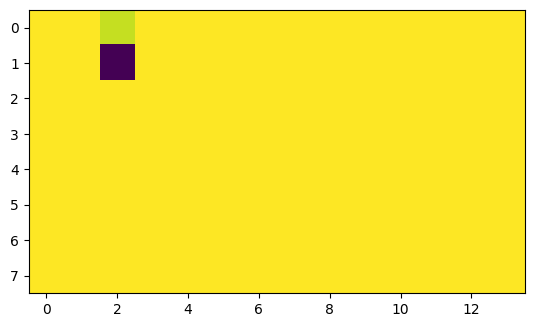

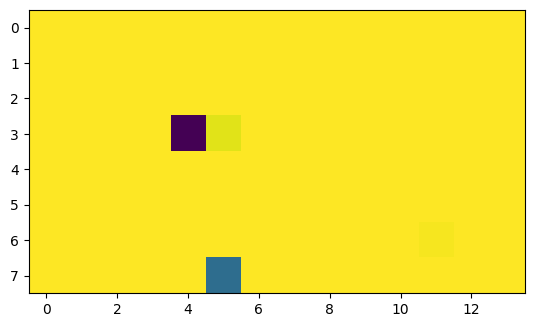

In [112]:
# Convert to 2d pixel array
roi = 6
corr_p_values_on = fdr_corrected_p_values[:lsn.n_pixels, roi].reshape(lsn.image_shape)
corr_p_values_off = fdr_corrected_p_values[lsn.n_pixels:, roi].reshape(lsn.image_shape)

plt.imshow(corr_p_values_off)
plt.figure()
plt.imshow(corr_p_values_on)

In [ ]:
lsn.

## Dan mimic

In [131]:
from stimulus_analysis.proba_utils import get_chisq_response_proba, get_chisq_sweep_categories

In [114]:
lsn.stim_table

,start,end,frame
0,635.117737,635.417969,0
1,635.434692,635.734924,1
2,635.751587,636.051819,2
3,636.068481,636.368774,3
4,636.385437,636.685791,4
...,...,...,...
1700,2096.668213,2096.968506,107
1701,2096.985107,2097.285400,108
1702,2097.302002,2097.602295,109
1703,2097.618896,2097.919189,110


In [147]:
lsn.sweep_responses

AttributeError: 'LocallySparseNoise' object has no attribute '_sweep_responses'

In [126]:
sweep_responses = np.zeros((len(lsn.stim_table), lsn.n_rois), dtype=lsn.event_traces.dtype)
for i in lsn.stim_table.index:
    start_frame = find_nearest(lsn.event_timestamps, lsn.stim_table.at[i, "start"])
    sweep_responses[i] = lsn.get_responses(start_frame, None, lsn_response_frame_window, trace_type="events")

sweep_responses.shape

(1705, 1234)

In [136]:
np.unique(lsn.stim_table.frame.values)

array([   0,    1,    2, ..., 1590, 1591, 1592])

In [137]:
stim_table_values = lsn.stim_table["frame"].values
unique_values = [lsn.stim_table[c].dropna().sort_values().unique() for c in ["frame"]]
unique_values

[array([   0,    1,    2, ..., 1590, 1591, 1592])]

In [143]:
p_values = get_chisq_response_proba(lsn.stim_table, stim_table_columns=["frame"], sweep_responses=sweep_responses, n_shuffles=100, debug=True)
p_values.shape

1593 categories: [   0    1    2 ... 1590 1591 1592]


(1234,)